# Subreddit Analysis

NLP-base analysis of different Reddit boards

## Imports

In [45]:
from os import environ as ENV, _Environ
from dotenv import load_dotenv
from psycopg2 import connect
from psycopg2.extras import RealDictCursor
from psycopg2.extensions import connection
import pandas as pd
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [46]:
load_dotenv()


def get_connection(config: _Environ) -> connection:
    """Returns a live DB connection."""
    return connect(
        host=config["DB_HOST"],
        user=config["DB_USER"],
        dbname=config["DB_NAME"],
        port=config["DB_PORT"],
        password=config["DB_PASSWORD"],
        cursor_factory=RealDictCursor
    )


conn = get_connection(ENV)

In [47]:
q = """
SELECT P.post_title, P.post_text, S.subreddit_name
FROM post AS P
LEFT JOIN subreddit AS S
USING (subreddit_id);
"""
with conn.cursor() as cur:
    cur.execute(q)
    data = cur.fetchall()
posts = pd.DataFrame(data)
pd.set_option('display.max_colwidth', 100)

In [48]:
posts.head()

,post_title,post_text,subreddit_name
0,r/AITAH Lounge,A place for members of r/AITAH to chat with each other,AITAH
1,AITA for Telling My Wife I Want Separate Bank Accounts After She Spent All Our Savings on a Vaca...,"My wife, Emma (32F), recently surprised me (34M) with a dream vacation. At first, I was excited,...",AITAH
2,AITAH for not wanting to marry any men because I don't want to risk my job security?\n\n,AITAH for not wanting to marry any men because I don't want to risk my job security?\n\nI (30F) ...,AITAH
3,WIBTA if I broke up with my fiancé so he could be happier with my sister?,I (25F) have been engaged to my fiancé (28M) for about a month now. He’s honestly amazing! He's ...,AITAH
4,AITAH for Hiding My Pregnancy From My Husband and My MIL,"I (25F) have been married to my husband (28M) for 3 years. \n\nMy husband, I will call him Joel,...",AITAH


In [49]:
posts.groupby('subreddit_name').count()

,post_title,post_text
subreddit_name,,
AITAH,26,26
askreddit,75,75
politics,27,27


In [50]:
vader = SentimentIntensityAnalyzer()

In [51]:
posts['text_sentiment'] = posts['post_text'].apply(lambda x: vader.polarity_scores(x)['compound'])
posts['title_sentiment'] = posts['post_title'].apply(lambda x: vader.polarity_scores(x)['compound'])
posts

,post_title,post_text,subreddit_name,text_sentiment,title_sentiment
0,r/AITAH Lounge,A place for members of r/AITAH to chat with each other,AITAH,0.0000,0.0000
1,AITA for Telling My Wife I Want Separate Bank Accounts After She Spent All Our Savings on a Vaca...,"My wife, Emma (32F), recently surprised me (34M) with a dream vacation. At first, I was excited,...",AITAH,0.8519,0.0772
2,AITAH for not wanting to marry any men because I don't want to risk my job security?\n\n,AITAH for not wanting to marry any men because I don't want to risk my job security?\n\nI (30F) ...,AITAH,0.9922,0.4574
3,WIBTA if I broke up with my fiancé so he could be happier with my sister?,I (25F) have been engaged to my fiancé (28M) for about a month now. He’s honestly amazing! He's ...,AITAH,0.9993,0.1531
4,AITAH for Hiding My Pregnancy From My Husband and My MIL,"I (25F) have been married to my husband (28M) for 3 years. \n\nMy husband, I will call him Joel,...",AITAH,0.2522,-0.2960
...,...,...,...,...,...
123,What is the best way to achieved your goals in life?,,askreddit,0.0000,0.6369
124,what is the funniest thing you have overheard in public?,,askreddit,0.0000,0.5574
125,"What's that one thing you were fine with, but the world taught you to be embarrassed about?",,askreddit,0.0000,-0.4310
126,What the reason you woke up today?,,askreddit,0.0000,0.0000


In [52]:
def categorise_sentiment(score:float) -> str:
    if score> 0.5:
        return 'positive'
    elif score < -0.5:
        return 'negative'
    else:
        return 'neutral'

posts['text_sentiment_category'] = posts['text_sentiment'].apply(categorise_sentiment)
posts['title_sentiment_category'] = posts['title_sentiment'].apply(
    categorise_sentiment)

/var/folders/g5/5x7wynhn6cb4twgcty_zbdtm0000gp/T/ipykernel_32621/2439520211.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posts['text_sentiment'])


<Axes: xlabel='text_sentiment', ylabel='Density'>

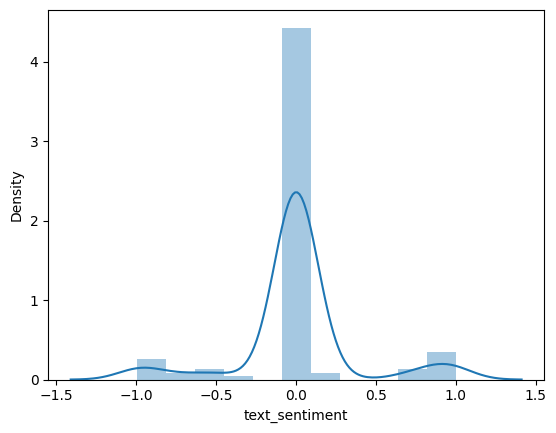

In [53]:
sns.distplot(posts['text_sentiment'])

In [54]:
print(posts['title_sentiment_category'].value_counts())
posts['text_sentiment_category'].value_counts()

title_sentiment_category
neutral     98
negative    18
positive    12
Name: count, dtype: int64


text_sentiment_category
neutral     106
positive     11
negative     11
Name: count, dtype: int64

In [55]:
posts.sort_values('title_sentiment_category',ascending=False)['post_title']

17     Update 2: AITA for telling my dad's ex that she could have been my mom if she didn't cheat on my...
100                                                   What is the best way to achieved your goals in life?
49                                      Billie Eilish endorses Harris: ‘Vote like your life depends on it’
77                                  Which do you consider to be the best video games of the last 10 years?
25                                                                      What is your secret to happiness? 
                                                      ...                                                 
103                                           what's something that's hated on way more than it should be?
43                                              Judge Aileen Cannon Failed to Disclose a Right-Wing Junket
41                   Trump is a threat to democracy. That's not rhetoric, it's verifiable fact | Editorial
36     Judge Who Tossed Trump’s Docs 

In [57]:
posts[posts['post_title'].str.lower().str.contains('trump')]['title_sentiment_category'].value_counts()

title_sentiment_category
neutral     5
negative    4
positive    1
Name: count, dtype: int64